In [1]:
# Import libraries:

import numpy as np
import cv2
import pandas as pd
from skimage.io import imread
import skimage as ski
import os
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
# from patchify import patchify
import tifffile as tiff
from pathlib import Path

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from PIL import Image

2024-10-21 10:58:12.302462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 10:58:12.322184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 10:58:12.342110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 10:58:12.347752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 10:58:12.365010: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

Gb_of_RAM = 20

tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*Gb_of_RAM)])


logical_gpus = tf.config.list_logical_devices('GPU')
print("Using", Gb_of_RAM, "Gb of RAM from ", len(gpus) ,"Physical GPU")

Num GPUs Available:  1
Using 20 Gb of RAM from  1 Physical GPU


2024-10-21 10:58:14.305525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20480 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
All_Images_names = sorted(list(Path('All Data/Images 1.5/').glob('*.tif')))

print('There are',len(All_Images_names), 'images:')

for x in range(len(All_Images_names)):
    print(All_Images_names[x])

There are 11 images:
All Data/Images 1.5/Image_0.tif
All Data/Images 1.5/Image_1.tif
All Data/Images 1.5/Image_10.tif
All Data/Images 1.5/Image_2.tif
All Data/Images 1.5/Image_3.tif
All Data/Images 1.5/Image_4.tif
All Data/Images 1.5/Image_5.tif
All Data/Images 1.5/Image_6.tif
All Data/Images 1.5/Image_7.tif
All Data/Images 1.5/Image_8.tif
All Data/Images 1.5/Image_9.tif


<h1>Training

In [4]:
from Training_lib import Load_training_data, Split_data, Main_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize

All_Images_names = sorted(list(Path('All Data/Augmented_Images/').glob('*.tif')))
All_masks_names  = sorted(list(Path('All Data/Augmented_Labels/').glob('*.tif')))

N         = 10000 #len(All_Images_names) # Number of images used in training/validation
SIZE_X    = 256                   # Width to resize images
SIZE_Y    = 256                   # Height to resize images
SIZE_Z    = 1                     # Number of channels in a single image
n_classes = 4                     # Number of classes for segmentation
shuf      = True                  # Shuffle parameter
Norm      = True                  # Normalization parameter

# Load training data
train_images, train_masks = Load_training_data(All_Images_names, All_masks_names, 
                                               SIZE_X, SIZE_Y, SIZE_Z, 
                                               Total_num_images = N,
                                               shuffle = shuf)

# Encode labels: since a multi-dimensional array is present, a flattening, encoding, and reshaping process is required
# Initialize label encoder
labelencoder = LabelEncoder()

# Get dimensions of the training mask
n, h, w = train_masks.shape

# Reshape mask to a 2D array for label encoding
train_masks_reshaped = train_masks.reshape(-1, 1)

# Fit label encoder and transform data to labels
train_masks_reshaped_encoded = train_masks_reshaped.ravel()
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

# Reshape encoded labels back to original mask shape
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# Process training images:
# Expand image dimensions
train_images = np.expand_dims(train_images, axis=-1)

# Normalize training images
if Norm == True:
    train_images = normalize(train_images, axis=1)

# Prepare mask input for training
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=-1)

# Split data into training, validation, and test sets
X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, X_test, y_test, y_test_cat = Split_data(train_images, train_masks_input, 
                                                                                                perc = 0, val_perc = 0.2, 
                                                                                                n_classes = n_classes)

Loading images...


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 585.56it/s]


Images loaded and processed. Shape: (10000, 256, 256)
Loading masks...


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 603.43it/s]


Masks loaded and processed. Shape: (10000, 256, 256)
Number of Training samples    =  8000
Number of Validation samples  =  2000
Number of Test samples        = 0


In [ ]:
import timeit
from Training_lib import Main_model

Save_name      = 'UNet_AllData_Norm_256px_1.5kV_v1'
model_folder   = 'Saved_models/'
history_folder = 'Saved_history/'

if not os.path.exists(model_folder) and not os.path.exists(history_folder):
    os.mkdir(model_folder)
    os.mkdir(history_folder)
    print("Model and history directory created")
else:
    print("Model and history directory already exists")

start = timeit.default_timer()

model,history = Main_model(X_train, y_train_cat, X_val, y_val_cat,
                           Save_name, model_folder, history_folder,
                           Training_param = True, Summary_param = False,
                           batch_size = 32, epochs = 250, learning_rate = 1e-3)

stop = timeit.default_timer()
total_time = stop - start

print("Total training time is = ", str(total_time)," seconds")

Model and history directory already exists
Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.5869 - loss: 0.9296 - val_accuracy: 0.8267 - val_loss: 0.4563
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8281 - loss: 0.4507 - val_accuracy: 0.8584 - val_loss: 0.3755
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8603 - loss: 0.3719 - val_accuracy: 0.8717 - val_loss: 0.3385
Epoch 4/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.8723 - loss: 0.3404 - val_accuracy: 0.8838 - val_loss: 0.3067
Epoch 5/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8816 - loss: 0.3154 - val_accuracy: 0.8874 - val_loss: 0.3012
Epoch 6/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8908 - loss: 0.2918 - val_accuracy: 0.8946 - val_loss: 0.2793
Epoch 7/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8977 - loss: 0.2732 - val_accuracy: 0.8991 - val_loss: 0.2687
Epoch 8/250
250/250 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# %% Plot training curves

# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,9), dpi= 100)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,9), dpi= 100)
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
plt.plot(epochs, acc1, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc1, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Testing data set

All_Test_Images_names = sorted(list(Path('All Data/Testing_Images/').glob('*.tif')))
All_Test_masks_names  = sorted(list(Path('All Data/Testing_Labels/').glob('*.tif')))

N         = len(All_Test_Images_names) # Number of images used in training/validation
SIZE_X    = 256                   # Width to resize images
SIZE_Y    = 256                   # Height to resize images
SIZE_Z    = 1                     # Number of channels in a single image
n_classes = 4                     # Number of classes for segmentation
shuf      = False                 # Shuffle parameter
Norm      = True                  # Normalization parameter

# Load training data
test_images, test_masks = Load_training_data(All_Test_Images_names, All_Test_masks_names, 
                                               SIZE_X, SIZE_Y, SIZE_Z, 
                                               Total_num_images = N,
                                               shuffle = shuf)

# Encode labels: since a multi-dimensional array is present, a flattening, encoding, and reshaping process is required
# Initialize label encoder
labelencoder = LabelEncoder()

# Get dimensions of the training mask
n, h, w = test_masks.shape

# Reshape mask to a 2D array for label encoding
test_masks_reshaped = test_masks.reshape(-1, 1)

# Fit label encoder and transform data to labels
test_masks_reshaped_encoded = test_masks_reshaped.ravel()
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

# Reshape encoded labels back to original mask shape
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

# Process training images:
# Expand image dimensions
test_images = np.expand_dims(test_images, axis=-1)

# Normalize training images
if Norm == True:
    test_images = normalize(test_images, axis=1)

# Prepare mask input for training
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=-1)

# Split data into training, validation, and test sets
_,_,_,_,_,_, X_test, y_test, y_test_cat = Split_data(test_images, test_masks_input, perc = 1, val_perc = 0, n_classes = n_classes)

Loading images...


100%|██████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 579.06it/s]


Images loaded and processed. Shape: (220, 256, 256)
Loading masks...


100%|██████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 650.46it/s]


Masks loaded and processed. Shape: (220, 256, 256)
Number of Training samples    = 0
Number of Validation samples  = 0
Number of Test samples        =  220


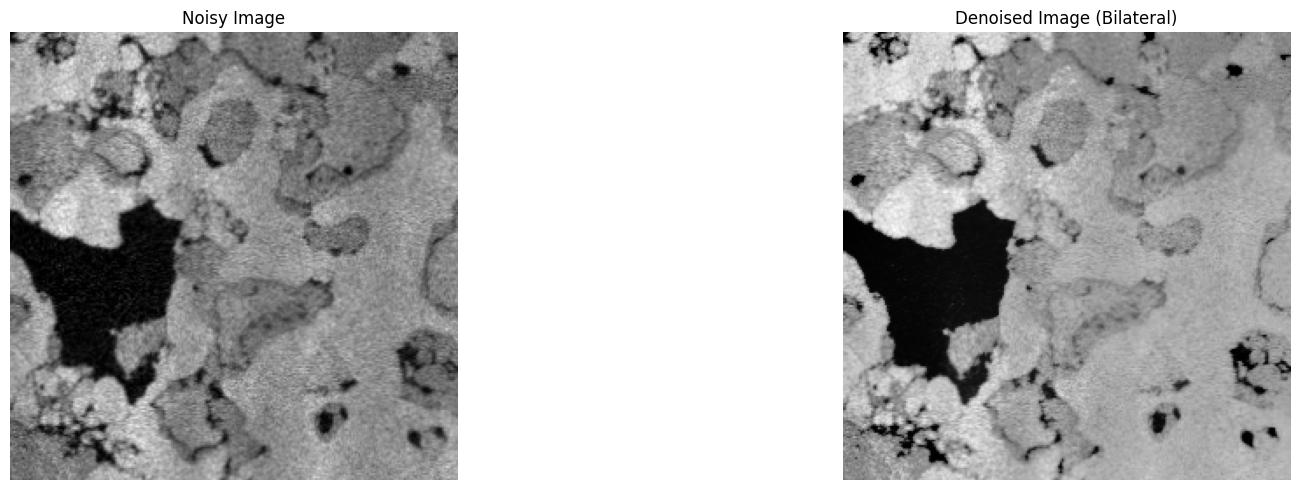

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.restoration import denoise_bilateral, denoise_wavelet
from skimage.util import random_noise

# Add random noise to the image
noisy_image = X_test[150].reshape((256,256))

# Apply bilateral denoising filter
denoised_image_bilateral = denoise_bilateral(noisy_image, sigma_color=0.01, sigma_spatial=20)

# Display the original, noisy, and denoised images
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].imshow(noisy_image, cmap='gray')
ax[0].set_title('Noisy Image')
ax[0].axis('off')

ax[1].imshow(denoised_image_bilateral, cmap='gray')
ax[1].set_title('Denoised Image (Bilateral)')
ax[1].axis('off')


plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Noisy acc =  0.895233154296875
Denoising acc =  0.8653106689453125


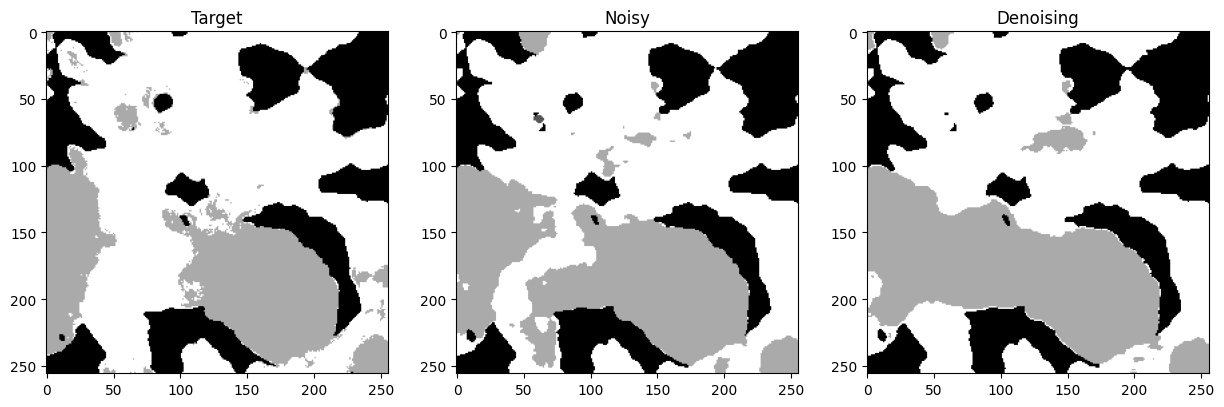

In [78]:
# Add random noise to the image
im = 0

noisy_image = X_test[im].reshape((256,256))

# Apply bilateral denoising filter
denoised_image_bilateral = denoise_bilateral(noisy_image, sigma_color=0.01, sigma_spatial=20)

y_pred_test1 = model.predict(noisy_image.reshape(1, 256, 256, 1))
y_pred_argmax_test1 = np.argmax(y_pred_test1, axis=-1)

y_pred_test2 = model.predict(denoised_image_bilateral.reshape(1, 256, 256, 1))
y_pred_argmax_test2 = np.argmax(y_pred_test2, axis=-1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize dynamically
target = y_test[im, :, :].reshape((256,256))
axs[0].imshow(target, cmap='gray')
axs[0].set_title('Target')

axs[1].imshow(y_pred_argmax_test1[im, :, :], cmap='gray')
axs[1].set_title('Noisy')
print('Noisy acc = ', calculate_accuracy(target,y_pred_argmax_test1[im, :, :]))

axs[2].imshow(y_pred_argmax_test2[im, :, :], cmap='gray')
axs[2].set_title('Denoising')
print('Denoising acc = ', calculate_accuracy(target,y_pred_argmax_test2[im, :, :]))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[ 80  27 212 125  79 187  17   4 195 101]


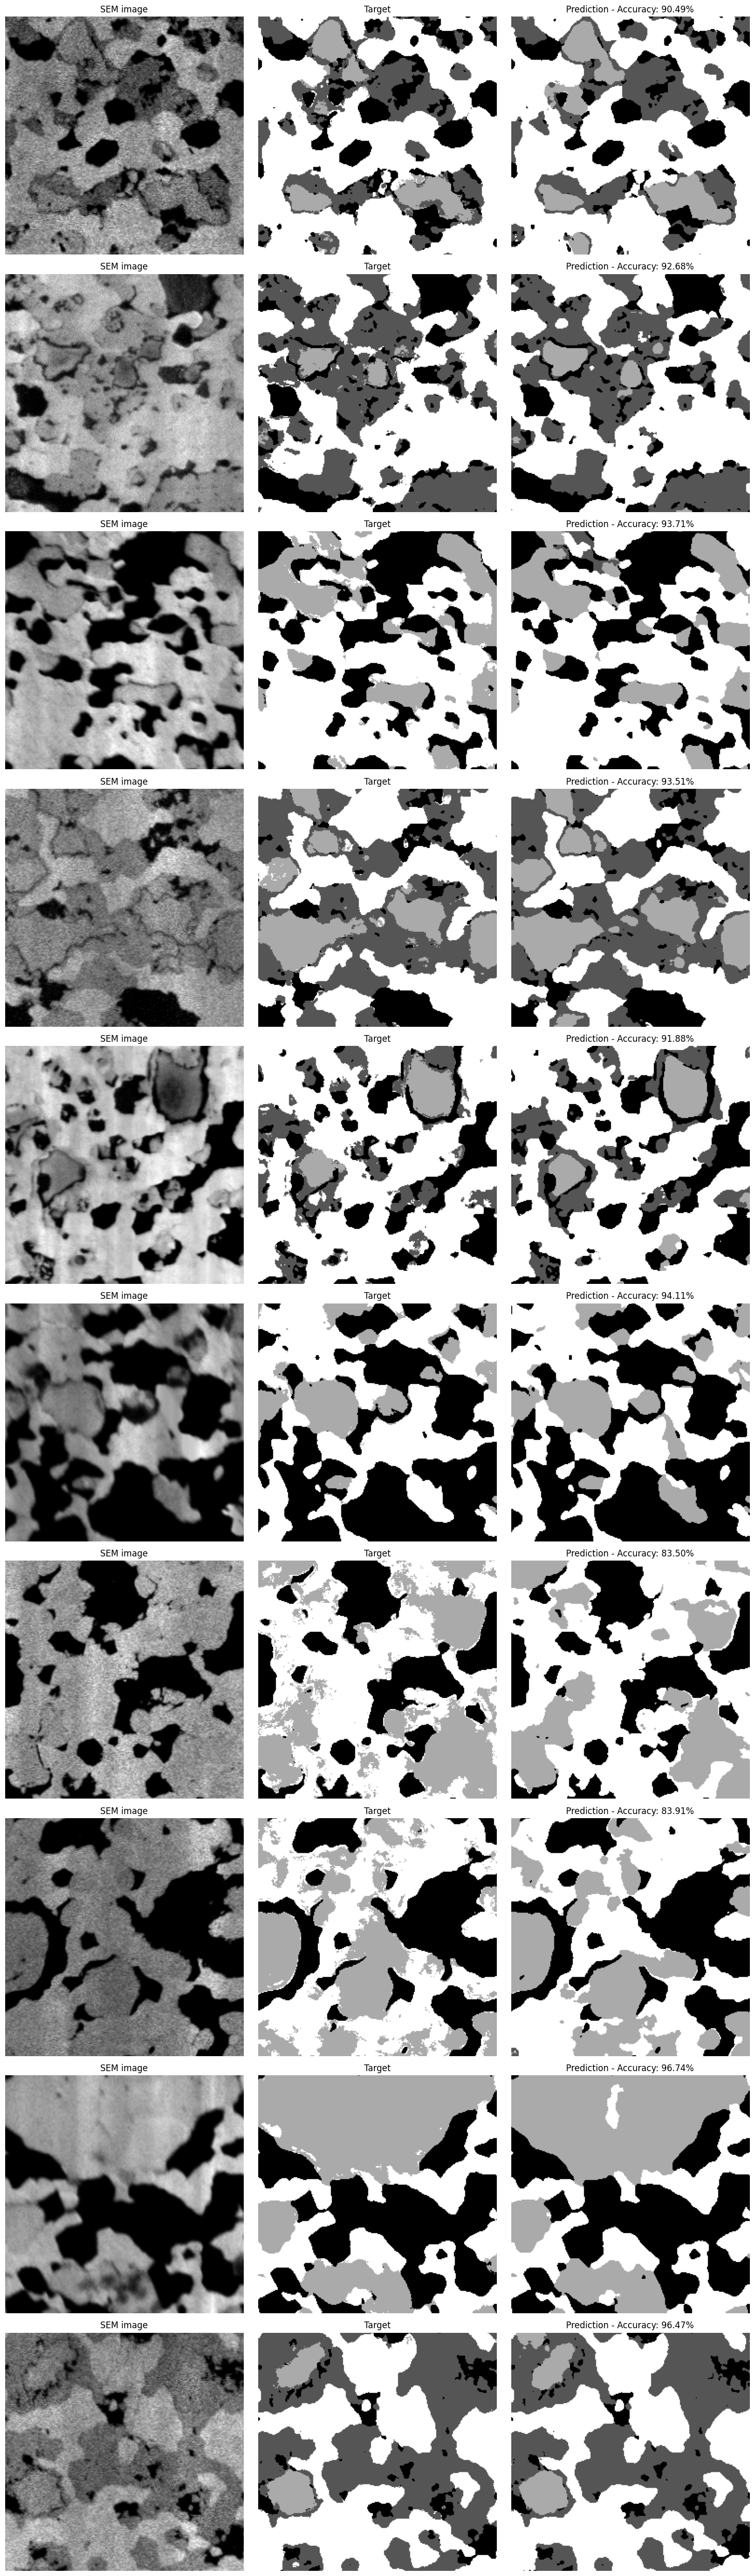

In [79]:
y_pred_test = model.predict(X_test)
y_pred_argmax_test = np.argmax(y_pred_test, axis=-1)

num_images = y_pred_argmax_test.shape[0]
rows = min(num_images, 10)  # Limit the number of rows to a reasonable number like 10

range_max = 219
num_values = 10

# Generate the random vector
random_vector = np.random.choice(range_max + 1, num_values, replace=False)
rows = len(random_vector)
print(random_vector)

fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # Adjust figsize dynamically

def calculate_accuracy(gt, pred):
    """Calculate the pixel accuracy between ground truth and prediction."""
    correct = np.sum(gt == pred)
    total = gt.size
    return correct / total

c = 0
for i in random_vector:  # Iterate only over the limited number of rows
    target = y_test[i, :, :].reshape((256,256))
    accuracy = calculate_accuracy(target, y_pred_argmax_test[i, :, :])
    accuracy_percent = accuracy*100  # Convert to percentage
    
    # First subplot for the SEM image
    axs[c, 0].imshow(X_test[i, :, :], cmap='gray')
    axs[c, 0].set_title('SEM image')
    axs[c, 0].axis('off')  # Hide the axis
    
    # Second subplot for the ground truth
    axs[c, 1].imshow(y_test[i, :, :], cmap='gray')
    axs[c, 1].set_title('Target')
    axs[c, 1].axis('off')  # Hide the axis
    
    # Third subplot for the prediction
    axs[c, 2].imshow(y_pred_argmax_test[i, :, :], cmap='gray')
    title = f'Prediction - Accuracy: {accuracy_percent:.2f}%'
    axs[c, 2].set_title(title)
    axs[c, 2].axis('off')  # Hide the axis
    c = c+1
    
# Display the plot
plt.tight_layout()
plt.show()

In [9]:
# Ensemble method

# Load training data path
    
All_Images_names = sorted(list(Path('New_patches/New data/Aug_Images_1.5kV/').glob('*.tif')))
All_masks_names  = sorted(list(Path('New_patches/New data/Aug_Labels_1.5kV/').glob('*.tif')))
    
N         = len(All_Images_names) # Number of images to use in training/validation/testing
SIZE_X    = 256    # Width to resize images
SIZE_Y    = 256    # Height to resize images
n_classes = 4      # Number of classes for segmentation
shuf      = True   # Shuffle parameter
Norm      = True   # Normalization parameter

    
train_images, train_masks = Load_training_data(All_Images_names, All_masks_names, 
                                                SIZE_X, SIZE_Y, 
                                                Total_num_images = N,
                                                shuffle = shuf)

labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    
train_images = np.expand_dims(train_images, axis=3)
if Norm == True:
    train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, X_test, y_test, y_test_cat = Split_data(train_images, train_masks_input, 
                                                                                                perc = 0.99, val_perc = 0.2, 
                                                                                                n_classes = n_classes)

for i in range(8, 10):
    
    print('Model number ',i+1)
    
    # train_images, train_masks = Load_training_data(All_Images_names, All_masks_names, 
    #                                                SIZE_X, SIZE_Y, 
    #                                                Total_num_images = N,
    #                                                shuffle = shuf)

    # labelencoder = LabelEncoder()
    # n, h, w = train_masks.shape
    # train_masks_reshaped = train_masks.reshape(-1, 1)
    # train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    # train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    
    # train_images = np.expand_dims(train_images, axis=3)
    # if Norm == True:
    #     train_images = normalize(train_images, axis=1)
    # train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
    # X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, X_test, y_test, y_test_cat = Split_data(train_images, train_masks_input, 
    #                                                                                                 perc = 0.99, val_perc = 0.2, 
    #                                                                                                 n_classes = n_classes)


    
    Save_name      = 'UNet_NewData_Norm_256px_1.5kV_'+str(i) #'New_data_256px_augmented_UNet_norm' 
    model_folder   = 'Ensemble_models/'
    history_folder = 'Ensemble_history/'

    model,history = Main_model(X_train, y_train_cat, X_val, y_val_cat,
                               Save_name, model_folder, history_folder,
                               Training_param = True, Summary_param = False,
                               batch_size = 32, epochs = 250, learning_rate = 1e-3)
    
    


Loading images...


100%|██████████████████████████████████████| 5400/5400 [00:08<00:00, 629.13it/s]


Images loaded and processed. Shape: (5400, 256, 256)
Loading masks...


100%|██████████████████████████████████████| 5400/5400 [00:08<00:00, 633.98it/s]
/nobackup/kd264511/envs/testenv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Masks loaded and processed. Shape: (5400, 256, 256)
Number of Training samples    =  4276
Number of Validation samples  =  1069
Number of Test samples        =  55
Model number  9
Learning rate for epoch 1 is 0.001000
Epoch 1/250


2024-07-01 16:32:56.077654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-01 16:32:58.703114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-07-01 16:32:59.560677: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-01 16:33:00.706423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


134/134 [==============================] - 26s 120ms/step - loss: 0.8750 - accuracy: 0.6129 - val_loss: 0.6677 - val_accuracy: 0.7313
Learning rate for epoch 2 is 0.001000
Epoch 2/250
134/134 [==============================] - 11s 80ms/step - loss: 0.6044 - accuracy: 0.7486 - val_loss: 0.5427 - val_accuracy: 0.7783
Learning rate for epoch 3 is 0.001000
Epoch 3/250
134/134 [==============================] - 9s 67ms/step - loss: 0.4978 - accuracy: 0.8027 - val_loss: 0.4223 - val_accuracy: 0.8366
Learning rate for epoch 4 is 0.001000
Epoch 4/250
134/134 [==============================] - 9s 70ms/step - loss: 0.3936 - accuracy: 0.8480 - val_loss: 0.3740 - val_accuracy: 0.8552
Learning rate for epoch 5 is 0.001000
Epoch 5/250
134/134 [==============================] - 9s 67ms/step - loss: 0.3553 - accuracy: 0.8628 - val_loss: 0.3324 - val_accuracy: 0.8715
Learning rate for epoch 6 is 0.001000
Epoch 6/250
134/134 [==============================] - 9s 68ms/step - loss: 0.3387 - accuracy: 0.86

2024-07-01 17:11:42.664864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


134/134 [==============================] - 13s 86ms/step - loss: 0.8485 - accuracy: 0.6308 - val_loss: 0.6368 - val_accuracy: 0.7380
Learning rate for epoch 2 is 0.001000
Epoch 2/250
134/134 [==============================] - 9s 66ms/step - loss: 0.5694 - accuracy: 0.7637 - val_loss: 0.5370 - val_accuracy: 0.7797
Learning rate for epoch 3 is 0.001000
Epoch 3/250
134/134 [==============================] - 9s 68ms/step - loss: 0.4481 - accuracy: 0.8251 - val_loss: 0.4344 - val_accuracy: 0.8265
Learning rate for epoch 4 is 0.001000
Epoch 4/250
134/134 [==============================] - 9s 66ms/step - loss: 0.3711 - accuracy: 0.8565 - val_loss: 0.4043 - val_accuracy: 0.8396
Learning rate for epoch 5 is 0.001000
Epoch 5/250
134/134 [==============================] - 9s 66ms/step - loss: 0.3424 - accuracy: 0.8680 - val_loss: 0.3268 - val_accuracy: 0.8718
Learning rate for epoch 6 is 0.001000
Epoch 6/250
134/134 [==============================] - 9s 67ms/step - loss: 0.3224 - accuracy: 0.8758

In [ ]:
y_pred_test = model.predict(X_test[0:10,:,:,:,:])

y_pred_argmax_test = np.argmax(y_pred_test, axis=-1)

plt.imshow(y_pred_argmax_test[5,:,:],cmap='gray')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
plt.plot(epochs, acc1, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc1, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# files_name = ['Saved_history/History_64px_augmented_UNet.json',
#               'Saved_history/History_128px_augmented_UNet.json',
#               'Saved_history/History_256px_augmented_UNet.json']#'Saved_history/History_First_UNet.json'
files_name = ['Saved_history/History_UNet_NewData_Norm_256px_10kV.json',
              'Saved_history/History_UNet_NewData_Norm_256px_1pt5kV.json',
              'Saved_history/History_UNet_NewData_Norm_256px_10and1pt5kV.json']

Num_plots = len(files_name)
epochs = 100

All_loss = np.zeros(epochs)
All_val_loss = np.zeros(epochs)
All_acc = np.zeros(epochs)
All_val_acc = np.zeros(epochs)

for i in range(len(files_name)):
    file_name = files_name[i]
    with open(file_name, 'r') as f:
        content = f.read()
        history_loaded = json.loads(content)

    All_loss = np.vstack([All_loss, history_loaded['loss']])
    All_val_loss = np.vstack([All_val_loss, history_loaded['val_loss']])
    All_acc = np.vstack([All_acc, history_loaded['accuracy']])
    All_val_acc = np.vstack([All_val_acc, history_loaded['val_accuracy']])


from matplotlib.pyplot import cm

color = iter(cm.gist_rainbow(np.linspace(0, 1, Num_plots)))
epochs = range(1, len(loss) + 1)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(Num_plots):
    loss     = All_loss[i+1,:]
    val_loss = All_val_loss[i+1,:]
    acc      = All_acc[i+1,:]
    val_acc  = All_val_acc[i+1,:]
    
    # Display Training loss
    c = next(color)
    axs[0].plot(epochs, loss, c=c, label='Training loss for case '+str(i+1))
    axs[0].plot(epochs, val_loss, c=c, linestyle = 'dashdot', label='Validation loss for case '+str(i+1), alpha=0.8)
    
    # Display Training accuracy
    axs[1].plot(epochs, acc, c=c, label='Training accuracy for case '+str(i+1))
    axs[1].plot(epochs, val_acc, c=c, linestyle = 'dashdot', label='Validation accuracy for case '+str(i+1), alpha=0.8)

    
axs[0].set_title('Loss')
axs[0].grid()
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

#IOU
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
# Using built-in keras function
from keras.metrics import MeanIoU
import numpy as np
import matplotlib.pyplot as plt

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Classes')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = values
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [ ]:
N = np.array([100,500,1000,2000,5000,10000])
data1 = np.array([78,89.9,90.4,91.6,92.7,93.1])
data2 = np.array([27,82,150,290,690,1280])

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(N, data1, '-*',color='blue')
ax1.tick_params(axis='y')
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Time (s)')  # we already handled the x-label with ax1
ax2.plot(N, data2,'-o',color='red')
ax2.tick_params(axis='y')
ax2.grid(linestyle = '--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Assuming you have X_test, y_test, and y_pred_argmax loaded appropriately
# and they are all NumPy arrays with shapes assumed to be [number_of_samples, height, width, channels]
N = 5 #y_test.shape[0]
fig, axs = plt.subplots(N, 3, figsize=(15,15))  # Create a grid of subplots

for i in range(N):
    # Display SEM image 
    axs[i, 0].imshow(X_test[i, :, :, 0], cmap='gray')
    axs[0, 0].set_title('SEM')
    axs[i, 0].axis('off')  # Hide the axis

    # Display Ground truth 
    axs[i, 1].imshow(y_test[i, :, :, 0], cmap='gray')
    axs[0, 1].set_title('Ground truth')
    axs[i, 1].axis('off')  # Hide the axis

    # Display prediction 
    axs[i, 2].imshow(y_pred_argmax[i, :, :], cmap='gray')
    axs[0, 2].set_title('Prediction')
    axs[i, 2].axis('off')  # Hide the axis

# plt.tight_layout()
# plt.show()

# Adjust subplots spacing
fig.subplots_adjust(hspace=0, wspace=0)  # Set the spacing between subplots to 0

# If you still see some white space, try to combine with tight_layout
plt.tight_layout(pad=1.0)  # Set the padding between and around subplots to 0

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))  # Create a grid of subplots

i=10
# Display SEM image 
axs[0].imshow(X_test[i, :, :, 0], cmap='gray')
axs[0].set_title('SEM')
axs[0].axis('off')  # Hide the axis

# Display Ground truth 
axs[1].imshow(y_test[i, :, :, 0], cmap='gray')
axs[1].set_title('Ground truth')
axs[1].axis('off')  # Hide the axis

# Display prediction 
axs[2].imshow(y_pred_argmax[i, :, :], cmap='gray')
axs[2].set_title('Prediction')
axs[2].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

In [ ]:
All_Images_names = sorted(list(Path('New_patches/Test_images/').glob('*.tif')))
All_Labels_names = sorted(list(Path('New_patches/Test_labels/').glob('*.tif')))

All_Im = []
GT = []
for im in range(len(All_Images_names)):

    filename_images = All_Images_names[im]
    I1 = ski.io.imread(filename_images)
    
    filename_labels = All_Labels_names[im]
    y_gt = ski.io.imread(filename_labels)

    All_Im.append(I1)
    GT.append(y_gt)

train_images = np.expand_dims(All_Im, axis=3)  


train_images = normalize(train_images, axis=1)
 
y_pred = model.predict(train_images)
y_pred_argmax = np.argmax(y_pred, axis=3)

N = 12 #y_test.shape[0]
fig, axs = plt.subplots(N, 3, figsize=(15,15))  # Create a grid of subplots

for i in range(N):
    # Display SEM image 
    axs[i, 0].imshow(train_images[i, :, :, 0], cmap='gray')
    axs[0, 0].set_title('SEM')
    axs[i, 0].axis('off')  # Hide the axis

    # Display Ground truth 
    axs[i, 1].imshow(GT[i], cmap='gray')
    axs[0, 1].set_title('Ground truth')
    axs[i, 1].axis('off')  # Hide the axis

    # Display prediction 
    axs[i, 2].imshow(y_pred_argmax[i], cmap='gray')
    axs[0, 2].set_title('Prediction')
    axs[i, 2].axis('off')  # Hide the axis

# plt.tight_layout()
# plt.show()

# Adjust subplots spacing
fig.subplots_adjust(hspace=0, wspace=0)  # Set the spacing between subplots to 0

# If you still see some white space, try to combine with tight_layout
plt.tight_layout(pad=1.0)  # Set the padding between and around subplots to 0

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))  # Create a grid of subplots

i=9
# Display SEM image 
axs[0].imshow(train_images[i, :, :, 0], cmap='gray')
axs[0].set_title('SEM')
axs[0].axis('off')  # Hide the axis

# Display Ground truth 
axs[1].imshow(GT[i], cmap='gray')
axs[1].set_title('Ground truth')
axs[1].axis('off')  # Hide the axis

# Display prediction 
axs[2].imshow(y_pred_argmax[i], cmap='gray')
axs[2].set_title('Prediction')
axs[2].axis('off')  # Hide the axis



plt.tight_layout()
plt.show()

In [ ]:
N = 12  # Total number of images to display
fig, axs = plt.subplots(4, 3, figsize=(15, 15))  # Create a grid of subplots

for i in range(N):
    # Compute the difference image
    Diff = np.abs(GT[i] - y_pred_argmax[i, :, :])
    
    # Determine the row and column index for the current subplot
    row = i // 3
    col = i % 3
    
    # Display the image in the appropriate subplot
    axs[row, col].imshow(Diff, cmap='gray')
    # axs[row, col].set_title('SEM')
    axs[row, col].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()


In [ ]:
for i in range(N):
    values,counts = np.unique(GT[i],return_counts = True)
    print('Values for '+str(i)+':',values)
    print('Counts for '+str(i)+':',counts)
    print('============================================')



In [ ]:
# Using built-in keras function
from keras.metrics import MeanIoU
import numpy as np
import matplotlib.pyplot as plt

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(GT, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Classes')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = values
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


<h1> Prediction for large image</h1>

In [ ]:
def Prediction_large(IMAGE, Patch_size, Norm, MODEL):

    """
    Segmentation prediction.

    Parameters:
    IMAGE (2D array) : Original image.
    Patch_size (int) : Indicates patch size to decompose image.
    Norm (bool)      : Normalization parameter, if True the data is normalized.
    MODEL (str)      : The model used for prediction.

    Returns:
    tuple: Tuple containing the predicted segmentation of the original image.
    """

   
    if len(IMAGE.shape) != 2:
        raise ValueError("Expected a 2-dimensional array, but received a " + str(len(IMAGE.shape)) + "-dimensional array.")

    "==========================================================================================================================="
    " Split image in four categories ==========================================================================================="
    "==========================================================================================================================="
    
    img_height,img_width = IMAGE.shape
    
    m_h = img_height//Patch_size
    m_w = img_width//Patch_size
    
    r_h = img_height%Patch_size
    r_w = img_width%Patch_size
    
    "==========================================================================================================================="
    " First category ==========================================================================================================="
    "==========================================================================================================================="
    all_patchs = []
    for j in range(m_h):
        for k in range(m_w):
            Patch = IMAGE[Patch_size*j:Patch_size*(j+1), Patch_size*k:Patch_size*(k+1)]
            single_patch_img = np.expand_dims(Patch, axis=2)  # If grayscale, ensure it's 3D
            single_patch_img = np.expand_dims(single_patch_img, axis=0)  # Add batch dimension
            single_patch_img = np.array(single_patch_img, dtype=np.uint8)
            if Norm == True:
                single_patch_img = normalize(single_patch_img, axis=1)
        
            # Prediction
            pred = MODEL.predict(single_patch_img)
            pred = np.argmax(pred, axis=3)[0]
            
            all_patchs.append(pred)
    
    # Reassemble the patches into a large image
    reconstructed_img = np.zeros((img_height, img_width), dtype=IMAGE.dtype)
    
    patch_index = 0
    for j in range(m_h):
        for k in range(m_w):
            reconstructed_img[Patch_size*j:Patch_size*(j+1), Patch_size*k:Patch_size*(k+1)] = all_patchs[patch_index]
            patch_index += 1
    
    "==========================================================================================================================="
    " Second category =========================================================================================================="
    "==========================================================================================================================="
    all_patchs2 = []
    for k in range(m_w):
        dd_h = (m_h-1)*Patch_size + r_h
        Patch1 = IMAGE[dd_h:IMAGE.shape[0], Patch_size*k:Patch_size*(k+1)]
        single_patch_img = np.expand_dims(Patch1, axis=2)  # If grayscale, ensure it's 3D
        single_patch_img = np.expand_dims(single_patch_img, axis=0)  # Add batch dimension
        single_patch_img = np.array(single_patch_img, dtype=np.uint8)
        if Norm == True:
            single_patch_img = normalize(single_patch_img, axis=1)
        
        # Prediction
        pred = MODEL.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)[0]
    
        all_patchs2.append(pred)
        
    reconstructed_img2 = np.zeros((img_height, img_width), dtype=IMAGE.dtype)
    
    patch_index = 0 # Assuming all full-size patches are added first in the list
    for k in range(m_w):
        dd_h = (m_h-1)*Patch_size + r_h
        reconstructed_img2[dd_h:IMAGE.shape[0], Patch_size*k:Patch_size*(k+1)] = all_patchs2[patch_index]
        patch_index += 1
    
    
    "==========================================================================================================================="
    " Third category ==========================================================================================================="
    "==========================================================================================================================="
    all_patchs3 = []
    for j in range(m_h):
        dd_w = (m_w-1)*Patch_size + r_w  
        Patch3 = IMAGE[Patch_size*j:Patch_size*(j+1), dd_w:IMAGE.shape[1]]
        single_patch_img = np.expand_dims(Patch3, axis=2)  # If grayscale, ensure it's 3D
        single_patch_img = np.expand_dims(single_patch_img, axis=0)  # Add batch dimension
        single_patch_img = np.array(single_patch_img, dtype=np.uint8)
        if Norm == True:
            single_patch_img = normalize(single_patch_img, axis=1)
        
        # Prediction
        pred = MODEL.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)[0]
    
        all_patchs3.append(pred)
    
    reconstructed_img3 = np.zeros((img_height, img_width), dtype=IMAGE.dtype)
    
    patch_index = 0 
    for j in range(m_h):
        dd_w = (m_w-1)*Patch_size + r_w  
        reconstructed_img3[Patch_size*j:Patch_size*(j+1), dd_w:IMAGE.shape[1]] = all_patchs3[patch_index]
        patch_index += 1
    
    
    "==========================================================================================================================="
    " Fourth category =========================================================================================================="
    "==========================================================================================================================="
    Patch4 = IMAGE[dd_h:IMAGE.shape[0], dd_w:IMAGE.shape[1]]
    single_patch_img = np.expand_dims(Patch4, axis=2)  # If grayscale, ensure it's 3D
    single_patch_img = np.expand_dims(single_patch_img, axis=0)  # Add batch dimension
    single_patch_img = np.array(single_patch_img, dtype=np.uint8)
    if Norm == True:
        single_patch_img = normalize(single_patch_img, axis=1)
        
    # Prediction
    pred = MODEL.predict(single_patch_img)
    pred = np.argmax(pred, axis=3)[0]
    
    reconstructed_img4 = np.zeros((img_height, img_width), dtype=IMAGE.dtype)
    reconstructed_img4[dd_h:IMAGE.shape[0], dd_w:IMAGE.shape[1]] = pred 

    "==========================================================================================================================="
    " Final image reconstruction ==============================================================================================="
    "==========================================================================================================================="
    I1 = np.maximum(reconstructed_img,reconstructed_img2)
    I2 = np.maximum(I1,reconstructed_img3)
    I_final = np.maximum(I2,reconstructed_img4)

    return I_final


In [ ]:
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from Smoothing import predict_img_with_smooth_windowing
# from simple_multi_unet_model import jacard_coef  
I_num = 5

All_Images_names = sorted(list(Path('DB-SOFC/Images/').glob('*.tif')))
# All_Images_names = sorted(list(Path('DB-SOFC/').glob('image005.tif')))

img =  ski.io.imread(str(All_Images_names[I_num]))
# img =  ski.io.imread(str(All_Images_names[0]))
if I_num == 9:
    img = img[1,:,:]
else:
    img = img[0,:,:]
    # img = img[:,:,0]

# model.load_weights('Augmented-UNet.hdf5')

All_masks_names = sorted(list(Path('DB-SOFC/Labels_mod2/').glob('*.tif')))
original_mask = cv2.imread(str(All_masks_names[I_num]), 0)

print(img.shape)
# plt.imshow(img[1,:,:])

In [ ]:
# Displaying the result

fig, axs = plt.subplots(1, 3, figsize=(15,15))  # Create a grid of subplots


# Display SEM image 
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide the axis

# Display Ground truth 
axs[1].imshow(original_mask, cmap='gray')
axs[1].set_title('Target')
axs[1].axis('off')  # Hide the axis

unpatched_prediction = Prediction_large(IMAGE = img, 
                                        Patch_size = 256,
                                        Norm = True,
                                        MODEL = model)

# Display prediction 
axs[2].imshow(unpatched_prediction, cmap='gray')
axs[2].set_title('Prediction')
axs[2].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()


sem_image = np.clip(img, 0, 255).astype(np.uint8)
ground_truth_image = (85 * original_mask).astype(np.uint8)
prediction_image = np.clip(85 * unpatched_prediction, 0, 255).astype(np.uint8)
    
# Save the images
# tiff.imwrite(f'Predictions/SEM_large/Image_{I_num}.tif', sem_image)
# tiff.imwrite(f'Predictions/Ground truth_large/Image_{I_num}.tif', ground_truth_image)
# tiff.imwrite(f'Predictions/Prediction_large/Image_{I_num}64.tif', prediction_image)


# plt.imshow(unpatched_prediction, cmap='gray')  # Use appropriate colormap if needed
# plt.axis('off')
# plt.show()

# print(unpatched_prediction.shape)

In [ ]:
array_int = unpatched_prediction.astype(np.float32)
array_int2 = original_mask.astype(np.float32)
Diff = np.abs(array_int2 - array_int)
Diff = np.array(Diff, dtype=np.uint8)

print(np.unique(Diff))
fig = plt.subplots(figsize=(15,15)) 
plt.imshow(original_mask, cmap='gray')
plt.axis('off')


tiff.imwrite(f'Predictions/NNN_{I_num}_new.tif', ground_truth_image)

In [ ]:
# Using built-in keras function
from keras.metrics import MeanIoU
import numpy as np
import matplotlib.pyplot as plt

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(original_mask, unpatched_prediction)
print("Mean IoU =", IOU_keras.result().numpy())

# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Classes')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = values
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [ ]:
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

input_img_8u = np.uint8(input_img * 255)

# Convert grayscale to RGB
input_img = cv2.cvtColor(input_img_8u, cv2.COLOR_GRAY2RGB)

# Print the new shape
input_img = np.array(input_img, dtype=np.float64)

In [ ]:
###################################################################################
#Predict using smooth blending

# input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, 
# called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)